<a href="https://colab.research.google.com/github/jamesgiddingsott/case_study/blob/main/casestudy_0_1_forms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Emeco Recruitment Case Study



## Description as Given

Topic:
Inventory Optimisation

Background:
Emeco holds rotable stock in our warehouses for planned and unplanned maintenance on our rental equipment.

The purpose of this case study is to determine, using the mock parameters provided below, the ideal level of stock required to support our fleet, while maximizing our return on capital. While holding an infinite number of components on the shelf would satisfy every foreseeable maintenance requirement, the components would not be utilized enough to justify the growing cost required to source and hold these components.

Objectives:


1)	Determine the recommended level of rotable stock required to fulfil 80% of demand in the 2023/24 financial year, while achieving 30% return on capital.


2)	Determine the average inventory balance over the 2023/24 financial year.

Required Inputs/Parameters:
Item Type – Transmission

Planned Demand:
* July 2023
* August 2023
*	August 2023
*	October 2023
*	November 2023
*	January 2024
*	January 2024
*	February 2024
*	March 2024
*	April 2024
*	April 2024
*	June 2024

<br>

Unplanned Demand: on average, one every 50 days

Distribution of Rental Equipment:  40% WA, 40% QLD, 20% NSW

Cost of Non-Rebuilt Stock: 1

Cost of Rebuilding Rotable Stock: 50,000 (saving 5,000)


Cost of Sourcing Stock from External Supplier (if inventory is unavailable): 55,000

Time to Rebuild Rotable Stock: ranges from 36-56 days

Time to Transit Rotable Stock to/from Site for Demand: ranges from 21-35 days
<br></br>





## ASSUMPTIONS

* Primary assumption is that the case study is to explore problem set using Python with associated visualizations to derive a solution in a way that can be clearly expressed to analytics team members and business decision makers.
* Delilvery dates are on the first day of the month or second day of the month if there are more than one deliveries in a month.
* Unplanned Demand represents failure or needed replacement of hardware already in the field, therefore currently existing field units is an arbitrary UNKNOWN amount.
* As parts are shipped out, there should be a part coming back into the facility for refurbishment.
* The parts, being rotable, are able to be refurbished as they come in to the facility, once repaired they can go back to out to the field when needed or stored on shelf / forward staged.
* Using Max Times on travel + refurbishment lead times used, biz case is better to have extra units than not enough to a limit as assuming customer can not have rental units down for extended periods (i.e. 35 days waiting on a part to arrive).
* Using 35 days EACH WAY to and from the field to for rotable and 35 days for shipping stock parts for planned demand.
* Mean Time Between Failure should be some randomized process, probably Poisson + Exponential distributions for amount of failures and inter-failure time gaps since only the mean failure rate is given for unplanned demand.
* Due to lead shipping times potentially beginning longer than the first delivery date, units need to ship in the previous year but are counted in THIS year?  Would need clarification from accounting personnel.
* Due to the above assumption the simulation actually begins calculating part demand ~ -35 days prior to 23/24 fiscal year to make sure delivery on 1/7/23 is possible
* Naive assumption is base rotable inventory should be: (total demand / 2), to account for refurbished product returning to the field filling planned or unplanned demand.



## Notes
---
1.  for a primer on stock management with considerations to lead times and safety stock.  https://web.mit.edu/2.810/www/files/readings/King_SafetyStock.pdf  


2.  Note: The critical value was found using a z-table. For z*, the sample size is not needed to pick a critical value, but for t*, the critical value changes depending on the sample size. A portion of the z-table is listed below with the part needed for our problem highlighted:
Confidence Level	z* Value
80%	1.28
85%	1.44
90%	1.64
95%	1.96
98%	2.33
99%	2.58
SOURCE:  https://www.stats4stem.org/introduction-to-confidence-intervals#:~:text=The%20value%20is%20determined%20by,99%25%20confidence%20level%20is%202.58.*italicized text*

#Packages and Imports

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from scipy.interpolate import CubicSpline

import matplotlib.pyplot as plt
import seaborn as sns


#MIT Method (Naive Method)

**Based on the following LINKS:**  
* https://web.mit.edu/2.810/www/files/readings/King_SafetyStock.pdf
* https://www.youtube.com/watch?v=p40SxvWFQ_A&t=1300s

<b>SAFETY STOCK</b> 


METHOD_3 = Z * DEMAND_STD * SQRT(AVG_LEAD_TIME), Uncertainty with demand


METHOD_4 = Z * AVG_SALES * LEAD_TIME_STD, Uncertainty on Lead time

METHOD_5 = Z * SQRT(AVG_LEAD_TIME * (DEMAND_STD^2)) + (AVG_SALES * (LEAD_TIME_STD^2))

METHOD_6 = Z * DEMAND_STD * SQRT(AVG_LEAD_TIME) + Z * AVG_SALES * LEAD_TIME_STD

In [2]:
#%%capture --no-display

samples = 10000  #num of times to sample distribution can chhange for speed

x = (np.random.poisson((1),size = samples))  #poisson sample dist 

# plt.hist(x, bins = 8)  # check shape

# sums all samples above 1 event per 50 days and gives pct chance it happens
demand_var = (np.sum(x > 1) / samples)



# Calc LEAD TIMES

tat_times = [36,56]
ship_times = [21,35]

tat_avg = (tat_times[0] + tat_times[1])/2


tat_max = tat_times[1]

ship_avg = (ship_times[0] + ship_times[1]) / 2


lead_avg = ship_avg + tat_avg


ship_max = ship_times[1]

lead_max = ship_max + tat_max

planned_demand = 12
unplanned_demand = (365/50)
total_demand = planned_demand + unplanned_demand
rot_inv_naive = (total_demand / 2)



### Safety Stock Calculation

In [3]:
# SAFETY STOCK CALCULATION
#----------------------------------*



# the demand_var number is the sum of all increments in the poisson distribution above 

# METHOD 3safety stock calc
# Z * sqrt(avg lead time / 365 days * .25 variability factor * rot inv)

Z=  {80:.85, 90:1.28, 100:4.09}  # from Z-score table


alpha = 80  #Select the area under the curve one wants to satisfy

s_stock = Z[alpha]* np.sqrt(lead_avg / 365 * rot_inv_naive * demand_var)

s_stock_max= Z[alpha] * np.sqrt(lead_max / 365 * rot_inv_naive * demand_var)


#----------------------------------*

total_inventory = (s_stock + rot_inv_naive)
total_inventory_max = (s_stock_max + rot_inv_naive)



# can we figure out what inital on shelf new inventory min needs to be???
#print("\nmax lead time intervals per year:", 365 / lead_max)
#print("\ninitial inventory:", np.ceil(total_inventory) / (365/lead_max))




In [4]:
#@title Naive Results

# RESULTS


print("\n\ndemand variability > 1 / 50 days:", round(demand_var,3))

print("\n\nrefurbish time avg:",tat_avg)

print("ship time avg",ship_avg)

print("avg lead time:", lead_avg)

print("\n", "--" * 4, "\n" *2)

print("\nplanned: {}, unplanned: {}".format(planned_demand,unplanned_demand))

print("\ntotal demand:", total_demand)

print("\n[Naive assumption is base rotable inventory should be: total demand / 2, to account for refurbished product returning to the field ]")

print("\nbase level rotable inventory:", rot_inv_naive)

print("\nInventory level for 80% of demand using safety stock calculation is Z score of .85 via formula:  Z * sqrt(avg lead time * rot inv * demand variability factor of ~25%)\n ")

print("confidence: {}%".format(alpha))

print("\nsafety stock:", round(s_stock,2))

print("safety stock max:", round(s_stock_max,2))

print("\n\ntotal needed inventory for 80% demand: ", round(total_inventory,2))

print("\n\ntotal needed inventory for 80% demand: ", round(total_inventory_max,2))

print("\nround up:", np.ceil(total_inventory))




demand variability > 1 / 50 days: 0.26


refurbish time avg: 46.0
ship time avg 28.0
avg lead time: 74.0

 -------- 



planned: 12, unplanned: 7.3

total demand: 19.3

[Naive assumption is base rotable inventory should be: total demand / 2, to account for refurbished product returning to the field ]

base level rotable inventory: 9.65

Inventory level for 80% of demand using safety stock calculation is Z score of .85 via formula:  Z * sqrt(avg lead time * rot inv * demand variability factor of ~25%)
 
confidence: 80%

safety stock: 0.61
safety stock max: 0.67


total needed inventory for 80% demand:  10.26


total needed inventory for 80% demand:  10.32

round up: 11.0


# Poisson Distribution for Unplanned Demand
---

ref:  https://numpy.org/doc/stable/reference/random/generated/numpy.random.poisson.html

---
* Only given mean unplanned demand rate with no distribution, using Poisson to simulate random events
* Running Poisson distribution, lamda 50, to select random unplanned demand intervals for the simulation
* Using inverse CDF from exponential distribution to calculate the unplanned demand cycle days, hand coded for speed.  Using scipy.stats was really slow and couldn't find similar functionality in numpy, equations derived from following two blog posts.
* https://towardsdatascience.com/gamma-distribution-intuition-derivation-and-examples-55f407423840
* https://timeseriesreasoning.com/contents/poisson-process/

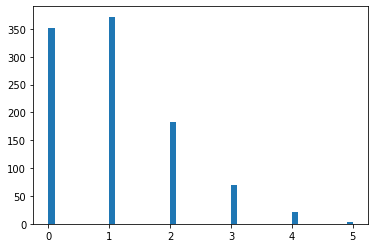

In [5]:
# Poisson Distribution and plot

# Number of events and associated occurances based on Poisson dist

s = np.random.poisson(1, 1000)
plt.hist(s, bins=50)
plt.show()

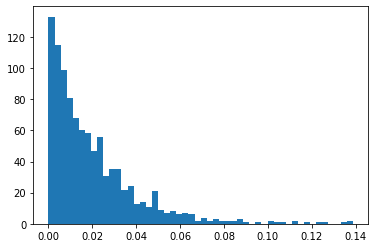

In [6]:
s_e = np.random.exponential(1/50, 1000)
plt.hist(s_e, bins=50)
plt.show()

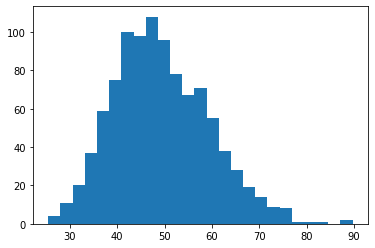

In [7]:
s_g = [np.random.gamma(25,2, 1000)]
plt.hist(s_g, bins=25)
plt.show()

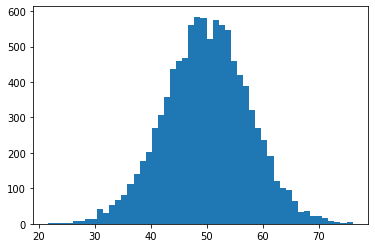

In [8]:
# This distribution gives more stable days for unplanned, used for testing

s_n = np.random.normal(50,7.5,10000)
plt.hist(s_n, bins=50)
plt.show()

# Via SIMULATION

### Planned Dates

In [9]:
planned_demand_dates = [
    '7/1/2023',
    '8/1/2023',
    '8/1/2023',
    '10/1/2023',
    '11/1/2023',
    '1/1/2024',
    '1/1/2024',
    '2/1/2024',
    '3/1/2024',
    '4/1/2024',
    '4/1/2024',
    '6/1/2024'
]

### VARIABLES

In [10]:
tat_max = 56 # Turn around time for refurbishment, Fixed max length 
tat_min = 36

ship_max =  35 # shipping time out from facility to customer, max length
ship_min = 21

d_avg_unplanned = 50

### Functions for Loop

In [11]:
'''

Function to remove doubles from list of integer days, 
doubles will be pushed back one day to remove calculation 
edge cases causes errors in the simulation

'''


def no_doubles(x):
  for i in range(len(x)):
    if i == 0:
      pass
    elif x[i] == x[i - 1]:
      x[i] = x[i] + 1
  return x

In [12]:
# Function of inverse exponential CDF to select inter arrival times for Poisson distribution

def build_unplanned_days(lam, arrival_time = 0, cycles = 15):

  """
    Simulate a Poisson process to generate a list of failure days.

    Args:
        lam (float): The rate parameter of the Poisson distribution, which determines the expected number of failures per unit time.
        arrival_time (float, optional): The starting time for the process. Defaults to 0.
        cycles (int, optional): The number of cycles to simulate. Defaults to 15.

    Returns:
        list: A list of failure days, represented as integers, in increasing order.

    Example:
        >>> build_unplanned_days(0.1, 0, 20)
        [0, 5, 8, 12, 21, 31, 36, 37, 46, 50, 52, 58, 67, 71, 80, 85, 87, 93, 98]
  """


  failure_days = []
  lam = lam
  U = np.random.uniform()
  arrival_time = arrival_time

  for i in np.arange(1, cycles):
    U = np.random.uniform()
    inter_arrival_time = -np.log((1.0 - U))/lam
    arrival_time += inter_arrival_time
    failure_days.append(int(arrival_time))

  # print(failure_days)
  avg = sum(np.diff(failure_days)) / len(failure_days)
  # print(avg)
  # print(failure_days)

  return failure_days


In [13]:
# This will be in the loop

def pre_build_schedule(demand_p, tat_min=56, tat_max=56, tat_std=0, ship_min=35, ship_max=35, ship_std = 0, 
                       d_u=50, d_std = 7.5, max_days = 365, sites = 3, site_prob = [.4,.4,.2]):

  """
      Calculates a preliminary build schedule for a rotable stock item based on demand and lead time data.
    
    Parameters
    ----------
    demand_p : list of int, planned demand schedule in integer days
        A list of planned demand values for the item, where each float represents the demand in a given month.
    tat_min : int, optional
        The minimum time it takes to rebuild a unit of the item, in days. Default is 56.
    tat_max : int, optional
        The maximum time it takes to rebuild a unit of the item, in days. Default is 56.
    tat_std : float, optional
        The standard deviation of the time it takes to rebuild a unit of the item, in days. Default is 0.
    ship_min : int, optional
        The minimum time it takes to ship a unit of the item to or from a site, in days. Default is 35.
    ship_max : int, optional
        The maximum time it takes to ship a unit of the item to or from a site, in days. Default is 35.
    ship_std : float, optional
        The standard deviation of the time it takes to ship a unit of the item to or from a site, in days. Default is 0.
    d_u : int, optional
        The average number of days between unplanned demand events for the item. Default is 50.
    d_std : float, optional
        The standard deviation of the number of days between unplanned demand events for the item. Default is 7.5.
    max_days : int, optional
        The maximum number of days to consider when calculating the preliminary build schedule. Default is 365.
    sites : int, optional
        The number of sites to consider when calculating the preliminary build schedule. Default is 3.
    site_prob : list of floats, optional
        A list of probabilities for each site, where the index of the probability corresponds to the index of the site. 
        The probabilities should add up to 1. Default is [.4, .4, .2].

  """


  # # Use this code to generate unplanned days based on normal distribution
  # unplanned_days = [0]
  # for i in np.arange(0,10): unplanned_days.append(int(np.random.normal(d_u, (d_std*3))) + unplanned_days[i])  #Random Normal with mean: 50, std 7.5 * some sigma factor
  # unplanned_days.pop(0)

  
  # # Use this code to generate unplanned days based on Poisson
  unplanned_days_pre_trim = build_unplanned_days(1/d_u, 0, 15)
  unplanned_days = [day for day in unplanned_days_pre_trim if day <= max_days]


  # Initial Day to Ship to hit planned demand
  initial_schedule = demand_p
  initial_ship_out_planned = [i - ship_max for i in demand_p]
  
  # Ship Units to customers
  ship_out_total = initial_ship_out_planned + unplanned_days
  ship_out_total.sort()
  shipout_total = no_doubles(ship_out_total)
  shipout_total_f= [day for day in shipout_total if day <= max_days]

  # Day old unit is sent back for repair
  send_to_repair = demand_p + unplanned_days
  send_to_repair.sort()
  send_to_repair = no_doubles(send_to_repair)
  send_to_repair_f = [day for day in send_to_repair if day <= max_days]

  # Day refurb is shipped, repaired, shipped back to site
  refurb_on_site = [i + ship_max + tat_max + ship_max for i in send_to_repair_f]
  refurb_on_site = no_doubles(refurb_on_site)
  refurb_back_on_site_f = [day for day in refurb_on_site if day <= max_days]

  # Where is Stuff Going
  location_map = [np.random.choice(3,p=site_prob) for i in shipout_total_f]


  # print("demand_p",demand_p)
  # print("initial_ship_out_planned", initial_ship_out_planned)
  # print("unplanned_days",unplanned_days)
  # print("This is the precalculated demand schedule:  shipout_total_f", shipout_total_f)
  # print(len(shipout_total_f))
  # print("send_to_repair",send_to_repair_f)
  # print("refurb_back_on_site_f", refurb_back_on_site_f)
  # print(len(refurb_back_on_site_f))
  # print("location_map",location_map)
  

  


  # return initial_schedule, unplanned_days, initial_ship_out_planned, ship_out_total, shipout_total_f
  # return shipout_total_f, unplanned_days, send_to_repair
  return shipout_total_f, refurb_back_on_site_f, location_map

### BUILD CORE DEMAND DAYS

In [14]:
 # Demand days based on initial list of monthly demand, assumed 1st of month is delilvery date
 
 demand_p = [(dt.strptime(planned_demand_dates[i], "%m/%d/%Y") - dt.strptime(planned_demand_dates[0], "%m/%d/%Y")).days for i in range(len(planned_demand_dates))]
 demand_p = no_doubles(demand_p)
 print(demand_p,)

[0, 31, 32, 92, 123, 184, 185, 215, 244, 275, 276, 336]


## Core Sim Loop

#### Simulation Details:
---

The Simulation works by first taking the precalculated days that derive from the initial list of months with assumption of delivery on the first of the month.

The loop records the outputs of the pre_build_schedule function.

inside this function:

* Schedule to ship is created using:  (original_sched - ship_time_max) + unplanned_days
* Sent to repair schedule is created:  (original_sched + unplanned days)
* Refurb Available onsite is created:  (repair_sched + (2 * ship_time_max) + turn-around-time_max)


The core sim loop then compares the refurb_avail sched with the ship_sched to determine if a refurb unit is available to meet demand in time.  If not a unit is removed from inventory and recorded.  

If a refurb is avail it is removed from the refurb inventory and recorded.

A running count of new_inventory used and refurb_inventory avialable and used are kept.

The total amount of inventory sent out is then divided between the 3 sites based on their probability of total rental market share as given.

All of the simulation runs are stored in a nested list for speed and converted to a dataframe afterwards.




In [15]:
# Simulation loop, input number of runs (10k runs ~10-30 secs)
# Commented out print statements were for debugging...

number_of_runs = 10_000

obsv_outer = []
obsv_inner = []

for q in np.arange(1,number_of_runs):

  new_inventory = 0
  refurb_inventory = 0
  refurb_run_use = 0
  site_dict = {0:0, 1:0, 2:0}

  ds, ra, site = pre_build_schedule(demand_p)
  # print(q,ra)

  obsv_inner = []
  new_inv_start = 0
  refurb_inv_start = 0
  ra_logg = [ra]
  ra_logg_len = len(ra)

  for i in np.arange(len(ds)):
    
    # print(ds[i], site[i])
    # check if refurb is avail
    if ra[0] < ds[i]:
      # print(ra[0], ds[i])
      refurb_inv_start = sum(np.array(ra)<= ds[i])
      # print(refurb_inventory)
      site_dict[site[i]] -= 1
      ra.pop(0)
      refurb_inventory = refurb_inv_start - 1
      refurb_run_use -= 1
      # print(ra)
    # Take from New_inventory
    else:
      # print(ds[i])
      new_inventory -= 1
      site_dict[site[i]] -= 1

    # Build Log
    # ra =[0] if len(ra) == 0 else ra = ra
    if len(ra) == 0:
      ra = [1000000] # max out ra if we have run out of units to keep record keeping algo going
    r0 = [q, ds[i], site[i], ra[0], new_inv_start, refurb_inv_start, new_inventory, refurb_inventory, refurb_run_use, site_dict, ra_logg, ra_logg_len]
    obsv_inner.append(r0)
    r0 = 0
  
  obsv_outer.append(obsv_inner)
  


In [16]:
# Flatten nested lists to create primary df
flatlist = [element for innerList in obsv_outer for element in innerList]

dfo = pd.DataFrame(flatlist, columns = ['sim_run', 'day', 'site', 'refurb_d_avail', 'new_inv_start'  , 'refurb_inv_start'  , 'new_inv_end', 'refurb_inv_end', 'refurb_run_use', 'site_counts', 'ra_logg', 'ra_logg_len'])
print(len(dfo))
dfo.tail(3)

193192


,sim_run,day,site,refurb_d_avail,new_inv_start,refurb_inv_start,new_inv_end,refurb_inv_end,refurb_run_use,site_counts,ra_logg,ra_logg_len
193189,9999,281,1,302,0,1,-11,0,-6,"{0: -9, 1: -7, 2: -3}","[[310, 311, 316, 341, 362]]",12
193190,9999,301,0,302,0,1,-12,0,-6,"{0: -9, 1: -7, 2: -3}","[[310, 311, 316, 341, 362]]",12
193191,9999,352,0,310,0,5,-12,4,-7,"{0: -9, 1: -7, 2: -3}","[[310, 311, 316, 341, 362]]",12


In [17]:
dfo.describe().T

,count,mean,std,min,25%,50%,75%,max
sim_run,193192.0,4996.059801,2888.795240,1.0,2489.0,5000.0,7490.0,9999.0
day,193192.0,150.413594,108.305734,-35.0,57.0,150.0,240.0,365.0
site,193192.0,0.799298,0.747511,0.0,0.0,1.0,1.0,2.0
refurb_d_avail,193192.0,1233.009985,32392.754930,126.0,126.0,157.0,234.0,1000000.0
new_inv_start,193192.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
refurb_inv_start,193192.0,1.122407,1.294890,0.0,0.0,1.0,2.0,12.0
new_inv_end,193192.0,-7.474424,3.210011,-19.0,-10.0,-8.0,-5.0,-1.0
refurb_inv_end,193192.0,0.513650,1.018156,0.0,0.0,0.0,1.0,11.0
refurb_run_use,193192.0,-2.872578,3.170946,-15.0,-5.0,-2.0,0.0,0.0
ra_logg_len,193192.0,13.067430,2.236810,8.0,11.0,13.0,14.0,22.0


In [18]:
#Create cummulative sum calcs to determine 80% demand threshold
mins = dfo.groupby('new_inv_end').count().reset_index()
mins['pct'] = mins['sim_run'] / len(dfo)
mins = mins.sort_values('new_inv_end',ascending=False)
mins['cumsum'] = mins['pct'].cumsum()
mins_f = mins[mins['cumsum'] >= .8].head(1)
mins_f


,new_inv_end,sim_run,day,site,refurb_d_avail,new_inv_start,refurb_inv_start,refurb_inv_end,refurb_run_use,site_counts,ra_logg,ra_logg_len,pct,cumsum
9,-10,24568,24568,24568,24568,24568,24568,24568,24568,24568,24568,24568,0.127169,0.833948


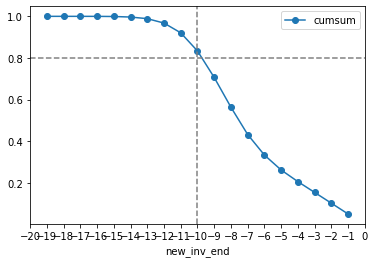

In [19]:
# Output plot of cumulative sum showing new units needed to meet ~80% of demand
plot = mins.plot('new_inv_end', 'cumsum', marker = 'o')
plot.axhline(.8, linestyle = '--', color = 'gray')
plot.axvline(-10, linestyle = '--', color = 'gray')
plt.xlim(-20,0)
plt.xticks(range(-20,1,1))
plt.show()

In [20]:
df_dict = pd.json_normalize(dfo['site_counts']) #explode site dictionary cell to df
result = pd.concat([dfo, df_dict], axis=1) #join dict_df to primary output

# result.describe().T

In [21]:
result['refurb_diff'] = result['refurb_inv_start'] - result['refurb_inv_end']
result['running_new_inventory_positive_start'] = result['new_inv_end'] + 11
result['total_inv'] = result['running_new_inventory_positive_start'] + result['refurb_inv_start']
print(len(result))
result.tail(5)

193192


,sim_run,day,site,refurb_d_avail,new_inv_start,refurb_inv_start,new_inv_end,refurb_inv_end,refurb_run_use,site_counts,ra_logg,ra_logg_len,0,1,2,refurb_diff,running_new_inventory_positive_start,total_inv
193187,9999,241,2,249,0,1,-10,0,-5,"{0: -9, 1: -7, 2: -3}","[[310, 311, 316, 341, 362]]",12,-9,-7,-3,1,1,2
193188,9999,245,0,249,0,1,-11,0,-5,"{0: -9, 1: -7, 2: -3}","[[310, 311, 316, 341, 362]]",12,-9,-7,-3,1,0,1
193189,9999,281,1,302,0,1,-11,0,-6,"{0: -9, 1: -7, 2: -3}","[[310, 311, 316, 341, 362]]",12,-9,-7,-3,1,0,1
193190,9999,301,0,302,0,1,-12,0,-6,"{0: -9, 1: -7, 2: -3}","[[310, 311, 316, 341, 362]]",12,-9,-7,-3,1,-1,0
193191,9999,352,0,310,0,5,-12,4,-7,"{0: -9, 1: -7, 2: -3}","[[310, 311, 316, 341, 362]]",12,-9,-7,-3,1,-1,4


In [22]:
#grab the last day for each simulation and get stats

result['match'] = result.sim_run == result.sim_run.shift(-1)
df_last_row = result[result['match'] == False]
df_last_row.describe().T

,count,mean,std,min,25%,50%,75%,max
sim_run,9999.0,5000.000000,2886.607005,1.0,2500.5,5000.0,7499.5,9999.0
day,9999.0,329.170217,23.047387,301.0,301.0,331.0,351.0,365.0
site,9999.0,0.800180,0.753916,0.0,0.0,1.0,1.0,2.0
refurb_d_avail,9999.0,17398.294629,129617.822679,158.0,297.0,310.0,311.0,1000000.0
new_inv_start,9999.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
refurb_inv_start,9999.0,3.057606,1.733056,1.0,2.0,3.0,4.0,12.0
new_inv_end,9999.0,-10.564256,1.590771,-19.0,-12.0,-10.0,-9.0,-7.0
refurb_inv_end,9999.0,2.057606,1.733056,0.0,1.0,2.0,3.0,11.0
refurb_run_use,9999.0,-8.756876,1.762730,-15.0,-10.0,-9.0,-7.0,-5.0
ra_logg_len,9999.0,12.818882,2.202696,8.0,11.0,13.0,14.0,22.0


# Visualizations

## Demand Picture

* 12 Units of Planned demand are scheduled for FY 23/24
* Based on the avg unplanned demand rate of every 50 days a theoretical distribution of potential outcomes can be derived from a Poisson distribution.
* One can see the simple avg would be around 7 to 8 but the distribution has signifigant spread 0 to upwards of 20 events in a year.

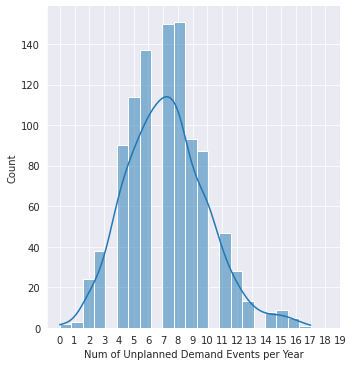

In [23]:
#@title Unplanned Demand Distribution
sns.set_style("darkgrid")


unplanned_demand_dist = np.random.poisson(365 / 50, 1000)
# sns.kdeplot(unplanned_demand_dist, fill=True)
sns.displot(unplanned_demand_dist, kde = True)
plt.xlabel("Num of Unplanned Demand Events per Year")
plt.xticks(np.arange(0,20,1))
plt.show()

## Simulation Results

* The results of the 10,000 simulation runs shows that for all simulated total demand profiles 10 inital units can fulfill 80% of the demand.  Falling in close agreement to the naive approach of 11 units.

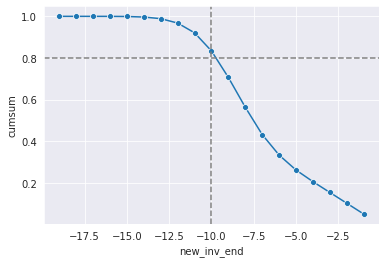

In [24]:
#@title 80% Total Demand Threshold vs Number of Units in Starting Inventory

sns.lineplot(x = mins['new_inv_end'], y = mins['cumsum'], marker = 'o')
plt.axhline(.8, linestyle = '--', color = 'gray')
plt.axvline(-10, linestyle = '--', color = 'gray')
plt.show()

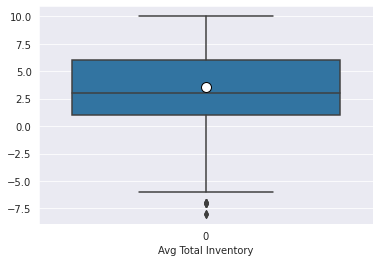

Avg Total Inventory Balance, via Simulation: 3.5


In [25]:
#@title Avg Total Inventory Balance
sns.boxplot(data = result['running_new_inventory_positive_start'], showmeans=True,meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
plt.xlabel("Avg Total Inventory")
plt.show()
print("Avg Total Inventory Balance, via Simulation:", round(result["running_new_inventory_positive_start"].mean(),1))

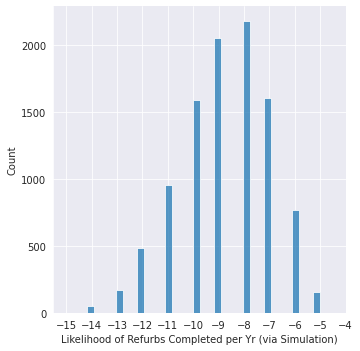

Mean Refurbs Observed: 9.0


In [26]:
#@title Likelihood of Refurbs Completed per Yr (via Simulation)

num_of_refurbs = [df_last_row['refurb_run_use'].max() * -1,
df_last_row['refurb_run_use'].mean() * -1,
df_last_row['refurb_run_use'].min() * -1]


sns.displot(data = df_last_row['refurb_run_use'])
plt.xticks(np.arange(-15,-3,1))
plt.xlabel("Likelihood of Refurbs Completed per Yr (via Simulation)")
plt.show()

print("Mean Refurbs Observed:", round(df_last_row['refurb_run_use'].mean() * -1,0))


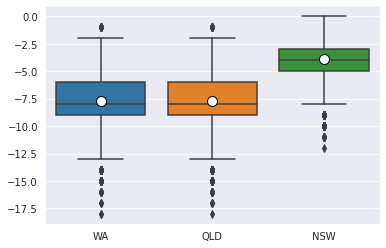

In [27]:
#@title Boxplot of Yearly Demand per Site via Simulation

df_sites = df_last_row[[0,1,2]]
df_sites = df_sites.rename(columns={0: 'WA', 1: 'QLD', 2:'NSW'})
sns.boxplot(data = df_sites, showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
plt.show()

# Financials

## ROC Function

In [28]:
def fin_calcs(new, unplanned, yearly_demand, rental_px = 55000, refurb_cost=50_000, cost_new = 1):

  """
    Perform financial calculations to determine the return on assets (ROA) for a rental property.

    Args:
        new (int): The number of new properties purchased.
        unplanned (list): A list of unplanned failure days, represented as integers.
        yearly_demand (int): The expected yearly demand for the rental property.
        rental_px (float, optional): The monthly rental price for each unit. Defaults to 55000.
        refurb_cost (int, optional): The cost of refurbishing each unit. Defaults to 50000.
        cost_new (int, optional): The cost of purchasing each new unit. Defaults to 1.

    Returns:
        float: The return on assets (ROA) for the rental property, rounded to 3 decimal places.

    Example:
        >>> unplanned_days = build_unplanned_days(0.1, 0, 20)
        >>> fin_calcs(10, unplanned_days, 200, rental_px=50000, refurb_cost=60000, cost_new=2)
        0.226
  """

  
  cost_new = new * cost_new
  yearly_demand = yearly_demand
  amount_refurb = yearly_demand - 10
  asset_value = rental_px * new
  
  gross_income = rental_px * yearly_demand * 1.0
  


  cost_refurb = refurb_cost * amount_refurb
  gross_costs = (cost_new + cost_refurb) * -1

  net_income = gross_income + gross_costs

  total_assets = new + asset_value + cost_refurb

  roa = round(net_income / total_assets,3)

  return roa


In [29]:
#@title ROC Output
ROC = fin_calcs(new = 11,unplanned = 8,yearly_demand = 20, rental_px = 55000, refurb_cost=50000, cost_new = 1)
print("{:.0%}".format(ROC))

54%


## Return on Capital

**Assumptions:**

Revenue per refurbished transmission = 55,000 (assuming rental price)

Cost per refurbished transmission = 50,000 (refurbishing cost)

Profit per refurbished transmission = 5,000

Cost of Non-Rebuilt Stock = 1 (seems very low, but was given value)

Refurbished units per year is roughly assumed to (total demand - 10), as it takes approx 2.5 months to recive and turn around on unit.
<br></br>
Number of New Units needed:  11 (10 + 1 safety stock unit)

Unplanned units expected:  8

Refurbished Units per year: 11


---
**Naive Approach**

Cost of New Inventory = 1 * 11 = 11

Cost of Refurbishing = 50,000 * 10 = 500,000

Asset Value = 55,000 * 11 = 605,000

Gross Income = 55,000 * 20 = 1,100,000

Costs = 11 + 500,000 = 500,011

Net Income = 1,100,000 - 500,011 = 599,989

Total Assets: value of new + refurb inventory:  605,000 + 500,000 + 11 = 1,105,011

ROA(ROC):  Net Income / Total Assets:  599,989 / 1,105,011 = **54.3%**






## Average Inventory Balance Over the Year


---
**Naive Approach**

*  (Beginning Inventory + Ending Inventory) / 2

Avg Balance = (11 initial units + (8 refurb units / 2 (for rotable nature))) / 2
Avg Balance = (11 + 4) / 2 = **7.5 Units**

# Further Work / Comments

* An interactive section where non-technical users where they can use controls to look at various scenarios to dial in how much risk they want to take in determining inventory amounts.  This was omitted her due to cross compatibility issues with various versions of Jupyter and Python package conflicts which could not ensure functionality at interview time.
* More shape can be giving to fluctuating shipping and turn around time schedules in the Naive case and in the simulation.  What is presented here should be close to worst case overall lead time scenarios.
* In reality the inter arrival time between failures causing unplanned demand is probably NOT exponentially distrbuted.  This assumes complete time independence when in reality the longer a machine is without maintenance the more likely it is to fail.  Further modelling work with a distribution like Weibull or similar may be more accurate.
* There could be more predictive work in determining roughly when to 'pre-ship' replacement units to a forward staging point closer to the sites- cutting down on shipping lead times for unplanned demand.
* Overall I was very surprised how accurate the naive approach was using the normal distribution to fairly accurately assess demand profiles with limited information on lead time variance.
* A lot of for-loops used in this, tried to use numpy processes where possible to enhance speed.  Potential for vectorization to run very fast if all parameters are pre-calculated.
* If this project was expanded to real world use-case it would probably be best practices to use a Discreet Event Simulator like SimPy which would handle a lot of the underlying simulations environment variables and allow for a much more detailed analysis and what-if scenarios without having to constantly re-write the simulation loop.

Planned Demand: 12
est. Unplanned Demand: 15
Total Demand: 27

Naive Rotable Total Demand: 13.5
Safety Stock: 1.0

Total Starting Inventory: 14.0




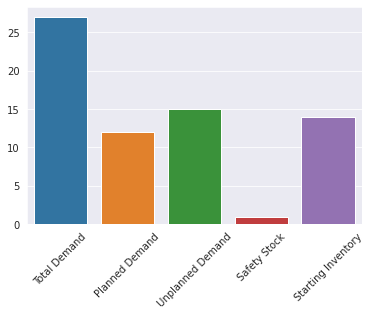

In [49]:
#@title Form for Naive Model

planned_demand_slider = 12 #@param {type:"slider", min:0, max:25, step:1}

unplanned_demand_slider = 15 #@param {type:"slider", min:0, max:25, step:1}


form_total_demand = planned_demand_slider + unplanned_demand_slider
form_rot_inv_naive = (form_total_demand / 2)


# -------------------------------------------
# the demand_var number is the sum of all increments in the poisson distribution above 

# METHOD 3safety stock calc
# Z * sqrt(avg lead time / 365 days * .25 variability factor * rot inv)

form_Z=  {80:.85, 90:1.28, 100:4.09}  # from Z-score table


form_alpha = 80  #Select the area under the curve one wants to satisfy

form_s_stock = form_Z[form_alpha]* np.sqrt(lead_avg / 365 * form_rot_inv_naive * .3)

form_s_stock_max= form_Z[form_alpha] * np.sqrt(lead_max / 365 * form_rot_inv_naive * .3)


#----------------------------------*

form_total_inventory = (form_s_stock + form_rot_inv_naive)
form_total_inventory_max = (form_s_stock_max + form_rot_inv_naive)

bar_xs = ['Total Demand', 'Planned Demand', 'Unplanned Demand', 'Safety Stock', 'Starting Inventory']
form_bar_list = [form_total_demand, planned_demand_slider, unplanned_demand_slider, 
                 np.ceil(form_s_stock_max), round(form_total_inventory_max, 0)]


sns.barplot(x=bar_xs, y=form_bar_list)
plt.xticks(rotation = 45)


print("Planned Demand:", planned_demand_slider)
print("est. Unplanned Demand:", unplanned_demand_slider)
print("Total Demand:",form_total_demand )
print("\nNaive Rotable Total Demand:", form_rot_inv_naive)
print("Safety Stock:", np.ceil(form_s_stock_max))
print("\nTotal Starting Inventory:", round(form_total_inventory_max, 0))
print("\n")
